# Projet de modélisation non supervisée des fonctionnalités de prédiction des tags 

## Imports

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
import nltk.data
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string
from langdetect import detect
import re
import spacy
from spacy.symbols import ORTH, NORM
from langdetect import detect_langs
import langid
from bs4 import BeautifulSoup

import gensim
from gensim import corpora, models
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import tqdm

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from collections import Counter

from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis


import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)


## Import dataset

In [3]:
data = pd.read_csv('./dataset/preprocessed_dataset.csv',sep=",")

In [4]:
data.head()

,body,tags
0,write daemon run emb platform need chang default rout devic accord interfac connect give time programat know use system rout del default rout add default gateway blah etc direct way updat solv particular problem discov patch pppd allow replacedefaultrout option patch also includ code programmat modifi rout tabl includ gentoo bug report,"c,linux,networking"
1,use gdi+ c++ two problem find canvasimg black chang color white mean want white canva draw thing canva clear canva mani thank,"canvas,gdi+"
2,write program need determin bit set know rotat word leav right shift access individu bite state use bitwis oper like xor,"assembly,bit-manipulation,mips"
3,consol applic server accept sever connect client possibl listen event close applic want event tell connect client gentl disconnect applic realli close solut thank,"java,events,listener"
4,attempt provid script solut read content file client machin browser solut work firefox internet explor pretti tri thing moment call write content filecont text area way browser concern safari chrome moment open suggest browser edit respons question want basic want hash file content togeth one time password client side send inform back verif,"javascript,html,file-io,sandbox"


## Modélisation non supervisée

Pour effectuer une modélisation non supervisée nous choisissons d'implémenter un modèle entrainé sur l'algorithme Latent Dirichlet Allocation (LDA par la suite).

L'algorithme a pour objectif d'établir une prédiction des topics relatifs à un ensemble de données textuelles. 

Il s'appuie sur 2 composants essentiels : 

    - Un dictionnaire, qui est l'ensemble des termes du langage
    - Le corpus, qui est l'ensemble des règles caractérisant les termes du langage (description, fréquence, etc, ...)


### Mise en place d'une baseline

On met en place une baseline à partir d'un LDA s'appuyant sur un bag of words simple.

#### Bag of Words

In [5]:
def tokenize(text):
    result = []
    #print(type(text))
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(token)
    return result

processed_body = data['body'].map(tokenize)
processed_body[:10]

dictionary = gensim.corpora.Dictionary(processed_body)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accord
1 add
2 allow
3 blah
4 bug
5 chang
6 code
7 connect
8 daemon
9 default
10 del


#### Dictionnaire

On crée pour chaque post un dictionnaire qui met en perspective combien de mots il comprend et combien de fois ce mot apparait.

In [6]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_body]

In [6]:
bow_corpus[1]

[(5, 1),
 (27, 1),
 (37, 1),
 (40, 1),
 (41, 3),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 2)]

#### Preview du Bag of Words

In [7]:
bow_show = bow_corpus[10]
for i in range(len(bow_show)):
    print("Word {} (\"{}\") appears {} time.".format(bow_show[i][0], 
                                               dictionary[bow_show[i][0]], 
                                                bow_show[i][1]))

Word 2 ("allow") appears 1 time.
Word 27 ("problem") appears 2 time.
Word 37 ("use") appears 4 time.
Word 38 ("way") appears 4 time.
Word 48 ("mean") appears 1 time.
Word 49 ("thank") appears 1 time.
Word 50 ("thing") appears 1 time.
Word 51 ("want") appears 2 time.
Word 53 ("access") appears 2 time.
Word 60 ("like") appears 3 time.
Word 80 ("realli") appears 1 time.
Word 83 ("solut") appears 1 time.
Word 104 ("pretti") appears 1 time.
Word 106 ("question") appears 1 time.
Word 117 ("work") appears 2 time.
Word 120 ("deriv") appears 5 time.
Word 128 ("implement") appears 3 time.
Word 129 ("list") appears 1 time.
Word 132 ("object") appears 1 time.
Word 135 ("type") appears 11 time.
Word 137 ("actual") appears 1 time.
Word 157 ("class") appears 2 time.
Word 163 ("day") appears 1 time.
Word 186 ("obvious") appears 1 time.
Word 201 ("turn") appears 1 time.
Word 211 ("come") appears 2 time.
Word 220 ("fair") appears 1 time.
Word 225 ("input") appears 1 time.
Word 261 ("abil") appears 1 tim

#### Exécution d'un LDA sur la base du Bag of Words

On définit un nombre de topic à 50 en rapport avec la volumétrie du dataset d'analyse.

In [7]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=50, 
                                       id2word=dictionary, passes=10, workers=7,
                                       random_state=100,chunksize=100,per_word_topics=True)

In [8]:
show = []
for idx, topic in lda_model.print_topics(-1):
    show.append('Topic: {} \nWords: {}'.format(idx, topic))
show[0:5]

['Topic: 0 \nWords: 0.042*"map" + 0.036*"user" + 0.035*"click" + 0.034*"count" + 0.030*"instanc" + 0.029*"menu" + 0.019*"abl" + 0.018*"mous" + 0.016*"use" + 0.016*"replac"',
 'Topic: 1 \nWords: 0.081*"search" + 0.057*"procedur" + 0.042*"store" + 0.031*"result" + 0.020*"status" + 0.018*"use" + 0.017*"txt" + 0.015*"forward" + 0.015*"gui" + 0.014*"execut"',
 'Topic: 2 \nWords: 0.065*"tag" + 0.054*"address" + 0.038*"product" + 0.020*"time" + 0.015*"work" + 0.015*"live" + 0.014*"calcul" + 0.013*"need" + 0.012*"new" + 0.011*"base"',
 'Topic: 3 \nWords: 0.067*"control" + 0.043*"valu" + 0.039*"form" + 0.028*"display" + 0.023*"select" + 0.023*"set" + 0.020*"chang" + 0.020*"edit" + 0.018*"user" + 0.015*"code"',
 'Topic: 4 \nWords: 0.074*"event" + 0.048*"form" + 0.023*"use" + 0.020*"handler" + 0.020*"branch" + 0.018*"submit" + 0.016*"merg" + 0.012*"work" + 0.011*"input" + 0.011*"handl"']

### Mesure des performances

Pour le LDA on mesure les indicateurs de perplexité et de cohérence du modèle 

In [9]:
"""
-----------------------------------------------------------------
Desc:   fonction de calcul de indicateur de performance
        du model
Input:  model
        corpus
        lemmas
        dictionnaire
Output: output console   

Traitements appliqués : 
- n/a 
-----------------------------------------------------------------
"""
def computeLDAPerfIndicators(model, corpus, lemmas, dictionary):
    #Perplexité
    print('\nPerplexity Score: ' + str(model.log_perplexity(corpus)))
    
    # Cohérence
    coherence_model_lda = CoherenceModel(model=model, texts=lemmas, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

In [10]:
computeLDAPerfIndicators(lda_model, bow_corpus, processed_body, dictionary)


Perplexity Score: -10.437418471056018

Coherence Score:  0.4039048022895308


### Amélioration: Feature engineering avec TF-IDF

Création d'un modèle TF-IDF sur bow_corpus

In [11]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.11565658447272077),
 (1, 0.05754279720573613),
 (2, 0.08449939921946943),
 (3, 0.17417548187125143),
 (4, 0.11731433042675461),
 (5, 0.060453178982257834),
 (6, 0.03860108639529847),
 (7, 0.08828895937818372),
 (8, 0.1798532627224299),
 (9, 0.2745013001030148),
 (10, 0.1844212620708418),
 (11, 0.12694560310863812),
 (12, 0.08792191448817356),
 (13, 0.1409138405283942),
 (14, 0.11953868087452152),
 (15, 0.19312919901941702),
 (16, 0.23103663331574822),
 (17, 0.16722631889183848),
 (18, 0.09772712316120548),
 (19, 0.045150802151398724),
 (20, 0.10443565681292098),
 (21, 0.04166015436551212),
 (22, 0.08380066486911258),
 (23, 0.097519179697227),
 (24, 0.31044352944617165),
 (25, 0.12221449203997013),
 (26, 0.24999035046391382),
 (27, 0.050960363661180175),
 (28, 0.15608991490035537),
 (29, 0.13051027319891328),
 (30, 0.10225719679793979),
 (31, 0.5485447910087591),
 (32, 0.05407512882911201),
 (33, 0.10140829919749607),
 (34, 0.06720342802533767),
 (35, 0.05709041924265162),
 (36, 

#### Exécution d'un LDA utilisant notre TF-IDF

In [12]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=dictionary, passes=10, workers=7,
                                       random_state=100,chunksize=100,per_word_topics=True)

In [13]:
show = []
for idx, topic in lda_model_tfidf.print_topics(-1):
    show.append('Topic: {} Word: {}'.format(idx, topic))
show[0:5]

['Topic: 0 Word: 0.028*"drag" + 0.011*"coordin" + 0.007*"cakephp" + 0.003*"birthday" + 0.002*"automag" + 0.002*"pin" + 0.001*"genr" + 0.001*"helper" + 0.000*"cake" + 0.000*"drop"',
 'Topic: 1 Word: 0.046*"servic" + 0.019*"interfac" + 0.017*"wcf" + 0.017*"proxi" + 0.017*"account" + 0.016*"certif" + 0.015*"setup" + 0.013*"domain" + 0.013*"jar" + 0.012*"runtim"',
 'Topic: 2 Word: 0.031*"layout" + 0.020*"cocoa" + 0.012*"worker" + 0.012*"secondari" + 0.011*"appl" + 0.010*"implicit" + 0.010*"sproc" + 0.010*"metric" + 0.006*"exclus" + 0.005*"tableview"',
 'Topic: 3 Word: 0.022*"json" + 0.017*"dictionari" + 0.013*"foreach" + 0.013*"traffic" + 0.011*"slide" + 0.010*"eval" + 0.009*"interrupt" + 0.006*"analyt" + 0.005*"distinct" + 0.005*"prepend"',
 'Topic: 4 Word: 0.038*"express" + 0.028*"webservic" + 0.025*"length" + 0.019*"parser" + 0.016*"cell" + 0.014*"vim" + 0.014*"pictur" + 0.014*"protocol" + 0.013*"equal" + 0.013*"textarea"']

#### Mesure des perfs

In [14]:
computeLDAPerfIndicators(lda_model_tfidf, corpus_tfidf, processed_body, dictionary)


Perplexity Score: -20.246456670825143

Coherence Score:  0.4862191394483353


On a amélioré le score de cohérence, les topics du modèle à partir du corpus TF-IDF sont plus proches sémantiquement du sens originel des posts.

#### Réglage des hyperparamètres

On joue sur les hyperparamètres suivants:

    - nombre de topics
    - alpha: sensibilité à la densité de topic par document
    - beta: sensibilité à la densité de mots par topic 

In [15]:
def compute_coherence_values(corpus, dictionary, lemmas, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                            workers=7,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmas, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 50
max_topics = 150
step_size = 10
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_tfidf)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.25)), 
               # gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus_tfidf, int(num_of_docs*0.75)), 
               corpus_tfidf]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# loop to fix hyperparam best value 1 each at a time
if 1 == 1:
    total = len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)
    pbar = tqdm.tqdm(total=total)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=dictionary, 
                                                  lemmas=processed_body,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 14%|█▍        | 87/600 [1:31:01<10:34:02, 74.16s/it]

#### Exploration des résultats

Pour chaque validation set on recherche le meilleur score de cohérence, qui nous donnera les meilleurs paramètres 'nombre de topics', 'alpha', 'beta'.

In [8]:
hyperparams_results = pd.read_csv('lda_tuning_results.csv',sep=",")

In [9]:
hyperparams_results.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,10,0.01,0.01,0.429141
1,75% Corpus,10,0.01,0.31,0.328894
2,75% Corpus,10,0.01,0.61,0.452352
3,75% Corpus,10,0.01,0.9099999999999999,0.503020
4,75% Corpus,10,0.01,symmetric,0.379833


In [16]:
results_75_pc = hyperparams_results[hyperparams_results['Validation_Set' ] == '75% Corpus']
results_75_pc_max = results_75_pc[results_75_pc['Coherence'] == results_75_pc['Coherence'].max()]
results_75_pc_max

,Validation_Set,Topics,Alpha,Beta,Coherence
84,75% Corpus,30,symmetric,symmetric,0.626901


In [17]:
results_100_pc = hyperparams_results[hyperparams_results['Validation_Set' ] == '100% Corpus']
results_100_pc_max = results_100_pc[results_100_pc['Coherence'] == results_100_pc['Coherence'].max()]
results_100_pc_max

,Validation_Set,Topics,Alpha,Beta,Coherence
512,100% Corpus,90,0.01,0.61,0.669062


On retient donc les hyperparams du meilleur score de cohérence (= 0.67)

In [ ]:
lda_model_tfidf_optimized = gensim.models.LdaMulticore(corpus_tfidf, num_topics=90, id2word=dictionary, passes=10, workers=7,
                                                       random_state=100, chunksize=100, per_word_topics=True,
                                                       alpha=0.01, eta=0.61)

In [19]:
show = []
for idx, topic in lda_model_tfidf_optimized.print_topics(-1):
    show.append('Topic: {} Word: {}'.format(idx, topic))
show[0:10]

['Topic: 0 Word: 0.000*"messga" + 0.000*"cxxtest" + 0.000*"expplain" + 0.000*"balm" + 0.000*"morphic" + 0.000*"idperson" + 0.000*"plugabbl" + 0.000*"thrive" + 0.000*"idproductcod" + 0.000*"dblclick"',
 'Topic: 1 Word: 0.000*"messga" + 0.000*"cxxtest" + 0.000*"expplain" + 0.000*"balm" + 0.000*"morphic" + 0.000*"idperson" + 0.000*"plugabbl" + 0.000*"thrive" + 0.000*"idproductcod" + 0.000*"dblclick"',
 'Topic: 2 Word: 0.000*"messga" + 0.000*"cxxtest" + 0.000*"expplain" + 0.000*"balm" + 0.000*"morphic" + 0.000*"idperson" + 0.000*"plugabbl" + 0.000*"thrive" + 0.000*"idproductcod" + 0.000*"dblclick"',
 'Topic: 3 Word: 0.000*"messga" + 0.000*"cxxtest" + 0.000*"expplain" + 0.000*"balm" + 0.000*"morphic" + 0.000*"idperson" + 0.000*"plugabbl" + 0.000*"thrive" + 0.000*"idproductcod" + 0.000*"dblclick"',
 'Topic: 4 Word: 0.000*"messga" + 0.000*"cxxtest" + 0.000*"expplain" + 0.000*"balm" + 0.000*"morphic" + 0.000*"idperson" + 0.000*"plugabbl" + 0.000*"thrive" + 0.000*"idproductcod" + 0.000*"dblclic

In [21]:
computeLDAPerfIndicators(lda_model_tfidf_optimized, corpus_tfidf, processed_body, dictionary)


Perplexity Score: -10.276846005178815

Coherence Score:  0.7255395469461173


On a donc amélioré le modèle par rapport à la baseline : 

    Coherence(baseline) = 0.35
    Coherence(opti) = 0.72

### Analyse des résultats obtenus

En suivant une démarche non supervisée nous devons comprendre l'information portée par le modèle résultant afin de l'exploiter.

#### Quel est le topic prédominant pour chaque post ?

Chaque post peut être représenté par 1 à n topics, on cherche à ressortir le topic prédominant 

In [31]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [32]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf_optimized, corpus=corpus_tfidf, texts=processed_body)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,49.0,0.8446,"file, tabl, use, class, way, code, work, applic, data, like","[programmat, edit, rout, tabl, write, daemon, run, emb, platform, need, chang, default, rout, devic, accord, interfac, connect, time, programat, know, use, rout, del, default, rout, add, default, gateway, blah, direct, way, updat, solv, particular, problem, discov, patch, pppd, allow, option, patch, includ, code, programmat, modifi, rout, tabl, includ, gentoo, bug, report]"
1,1,49.0,0.7922,"file, tabl, use, class, way, code, work, applic, data, like","[eras, content, graphic, gdi, use, gdi, problem, canvasimg, black, chang, color, white, mean, want, white, canva, draw, thing, canva, clear, canva, mani, thank]"
2,2,49.0,0.8187,"file, tabl, use, class, way, code, work, applic, data, like","[access, state, individu, bit, word, mip, write, program, need, determin, bit, set, know, rotat, word, leav, right, shift, access, individu, bite, state, use, bitwis, oper, like, xor]"
3,3,49.0,0.8148,"file, tabl, use, class, way, code, work, applic, data, like","[handl, close, applic, event, java, consol, applic, server, accept, sever, connect, client, possibl, listen, event, close, applic, want, event, tell, connect, client, gentl, disconnect, applic, realli, close, solut, thank]"
4,4,49.0,0.8604,"file, tabl, use, class, way, code, work, applic, data, like","[read, file, content, client, javascript, browser, attempt, provid, script, solut, read, content, file, client, machin, browser, solut, work, firefox, internet, explor, pretti, tri, thing, moment, write, content, filecont, text, area, way, browser, concern, safari, chrome, moment, open, suggest, browser, edit, respons, question, want, basic, want, hash, file, content, togeth, time, password, client, send, inform, verif]"
5,5,49.0,0.8308,"file, tabl, use, class, way, code, work, applic, data, like","[determin, object, deriv, collect, type, want, determin, generic, object, type, method, type, paramet, collect, type, typic, send, generic, list, collect, type, use, helper, function, best, test, implement, ienumer, code, look, like, updat, gmt, possibl, extend, solut, howev, work, list, ienumer, list, deriv]"
6,6,49.0,0.8164,"file, tabl, use, class, way, code, work, applic, data, like","[altern, way, free, dynam, alloc, memori, use, free, function, studi, test, wonder, equival, free, ptr, understand, work, free, function, actual, tell, memori, ptr, avail, use, sorri, kind, noob, question, help, appreci]"
7,7,49.0,0.8915,"file, tabl, use, class, way, code, work, applic, data, like","[advic, start, web, program, design, littl, backround, yr, old, high, school, degre, lot, free, time, colleg, work, complet, new, web, program, coupl, day, class, photoshop, illustr, dreamweav, firework, indesign, day, class, mean, pro, familiar, adob, program, teacher, freelanc, web, design, tell, adob, program, learn, html, xhtml, css, flash, java, good, shape, regard, job, tell, good, design, program, realli, good, job, wonder, anyon, advic, inform, basic, noob, start, scratch, realli, want, profess, lynda, com, tri, program, stuff, tri, turn, skill, job, best, case, scenario, eventu, freelanc, support, obvious, far, away, advic, great, appreci]"
8,8,49.0,0.8908,"file, tabl, use, class, way, code, work, applic, data, like","[sanit, user, input, proper, content, encod, save, applic, user, input, text, form, data, save, mysql, databas, collat, output, xml, encod, utf, problem, peopl, tend, cut, past, inform, sourc, instanc, microsoft, word, document, pdfs, instanc, input, text, charact, incorrect, output, encod, thing, like, smart, quot, come, document, caus, problem, obvious, transform, otherwis, work, xml, charact, illeg, sanitis, input, previous, use, fair, brute, forc, method, thing, like, moron, script, consist, long, list, search, replac, oper, best, way, way, set, accept, charset, attribut, form, browser, browser, like, problem, come, databas, accept, charact, reserv, c

#### Post le plus représentatif par topic

In [33]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.0111,"libxml, libcl, solari, sl, sax, risc, preload, pa, wont, compuls","[miss, numer, alphanumer, python, write, function, python, determin, list, filenam, match, pattern, file, miss, pattern, exampl, input, desir, output, input, kumar, txt, kumar, txt, kumar, txt, kumar, txt, kumar, txt, kumar, txt, kumar, txt, kumar, txt, kumar, txt, kumar, txt, desir, output, kumar, txt, kumar, txt, kumar, txt, kumar, txt]"
1,49.0,0.9087,"file, tabl, use, class, way, code, work, applic, data, like","[link, packag, option, execut, action, base, exist, avail, packag, runtim, perspect, cross, applic, applet, java, access, servic, link, packag, option, execut, action, base, exist, avail, packag, alreadi, load, runtim, think, way, resolv, issu, app, share, object, servic, load, higher, level, class, loader, like, reflect, way, sure, implement, deriv, class, way, need, add, specif, listen, deriv, specif, option, class, load, listen, use, applet, class, loader, intern, fail, want, add, swing, guarante, avail, use, reflect, method, add, listen, creat, frame, listen, work, relat, class, base, classload, need, creat, thread, use, classload, know, swing, class, load, reliabl, simpli, tri, set, class, loader, exist, ...]"


In [61]:
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,49.0,0.8446,"file, tabl, use, class, way, code, work, applic, data, like","[programmat, edit, rout, tabl, write, daemon, run, emb, platform, need, chang, default, rout, devic, accord, interfac, connect, time, programat, know, use, rout, del, default, rout, add, default, gateway, blah, direct, way, updat, solv, particular, problem, discov, patch, pppd, allow, option, patch, includ, code, programmat, modifi, rout, tabl, includ, gentoo, bug, report]"
1,1,49.0,0.7922,"file, tabl, use, class, way, code, work, applic, data, like","[eras, content, graphic, gdi, use, gdi, problem, canvasimg, black, chang, color, white, mean, want, white, canva, draw, thing, canva, clear, canva, mani, thank]"
2,2,49.0,0.8187,"file, tabl, use, class, way, code, work, applic, data, like","[access, state, individu, bit, word, mip, write, program, need, determin, bit, set, know, rotat, word, leav, right, shift, access, individu, bite, state, use, bitwis, oper, like, xor]"


#### Comparaison des distribution de la fréquence de mots posts vs topics

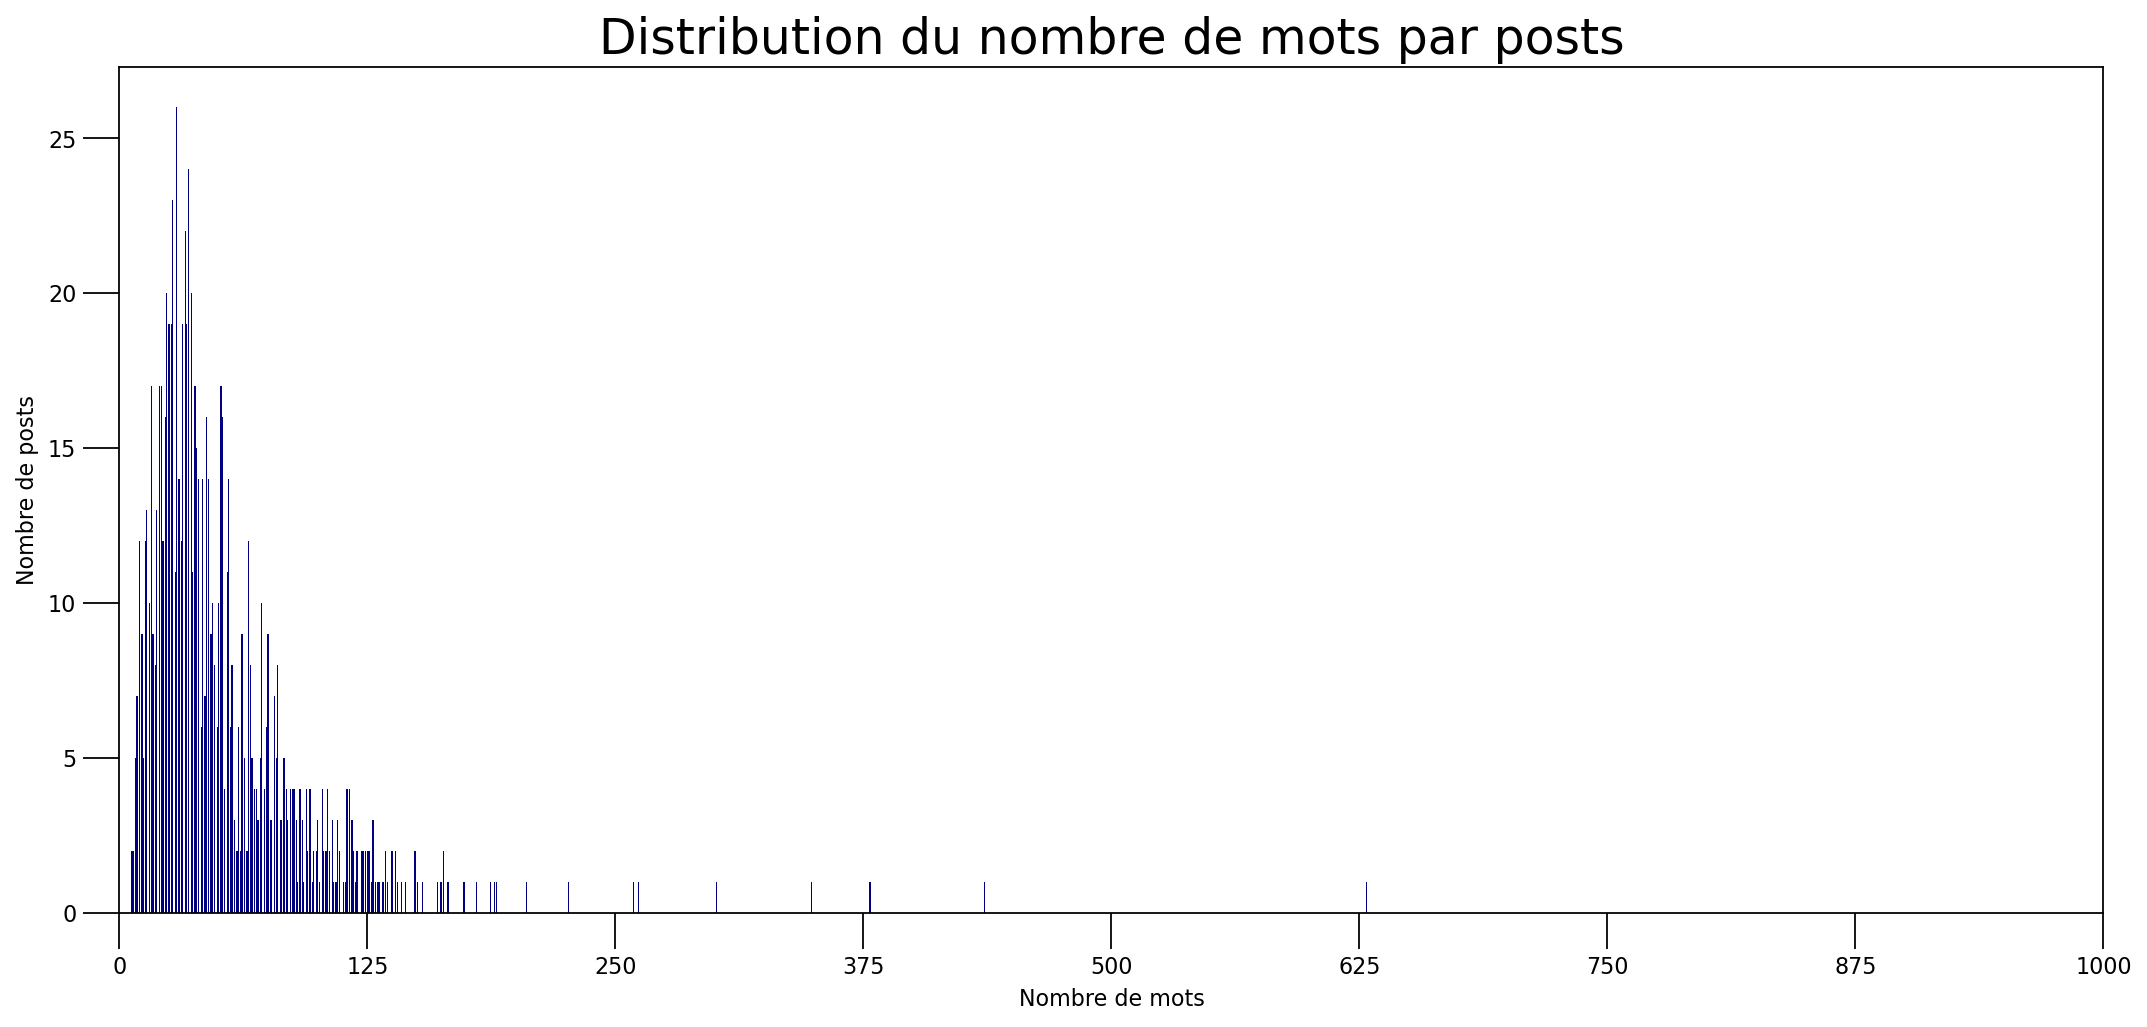

In [43]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
"""
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
"""
plt.gca().set(xlim=(0, 1000), ylabel='Nombre de posts', xlabel='Nombre de mots')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution du nombre de mots par posts', fontdict=dict(size=22))
plt.show()

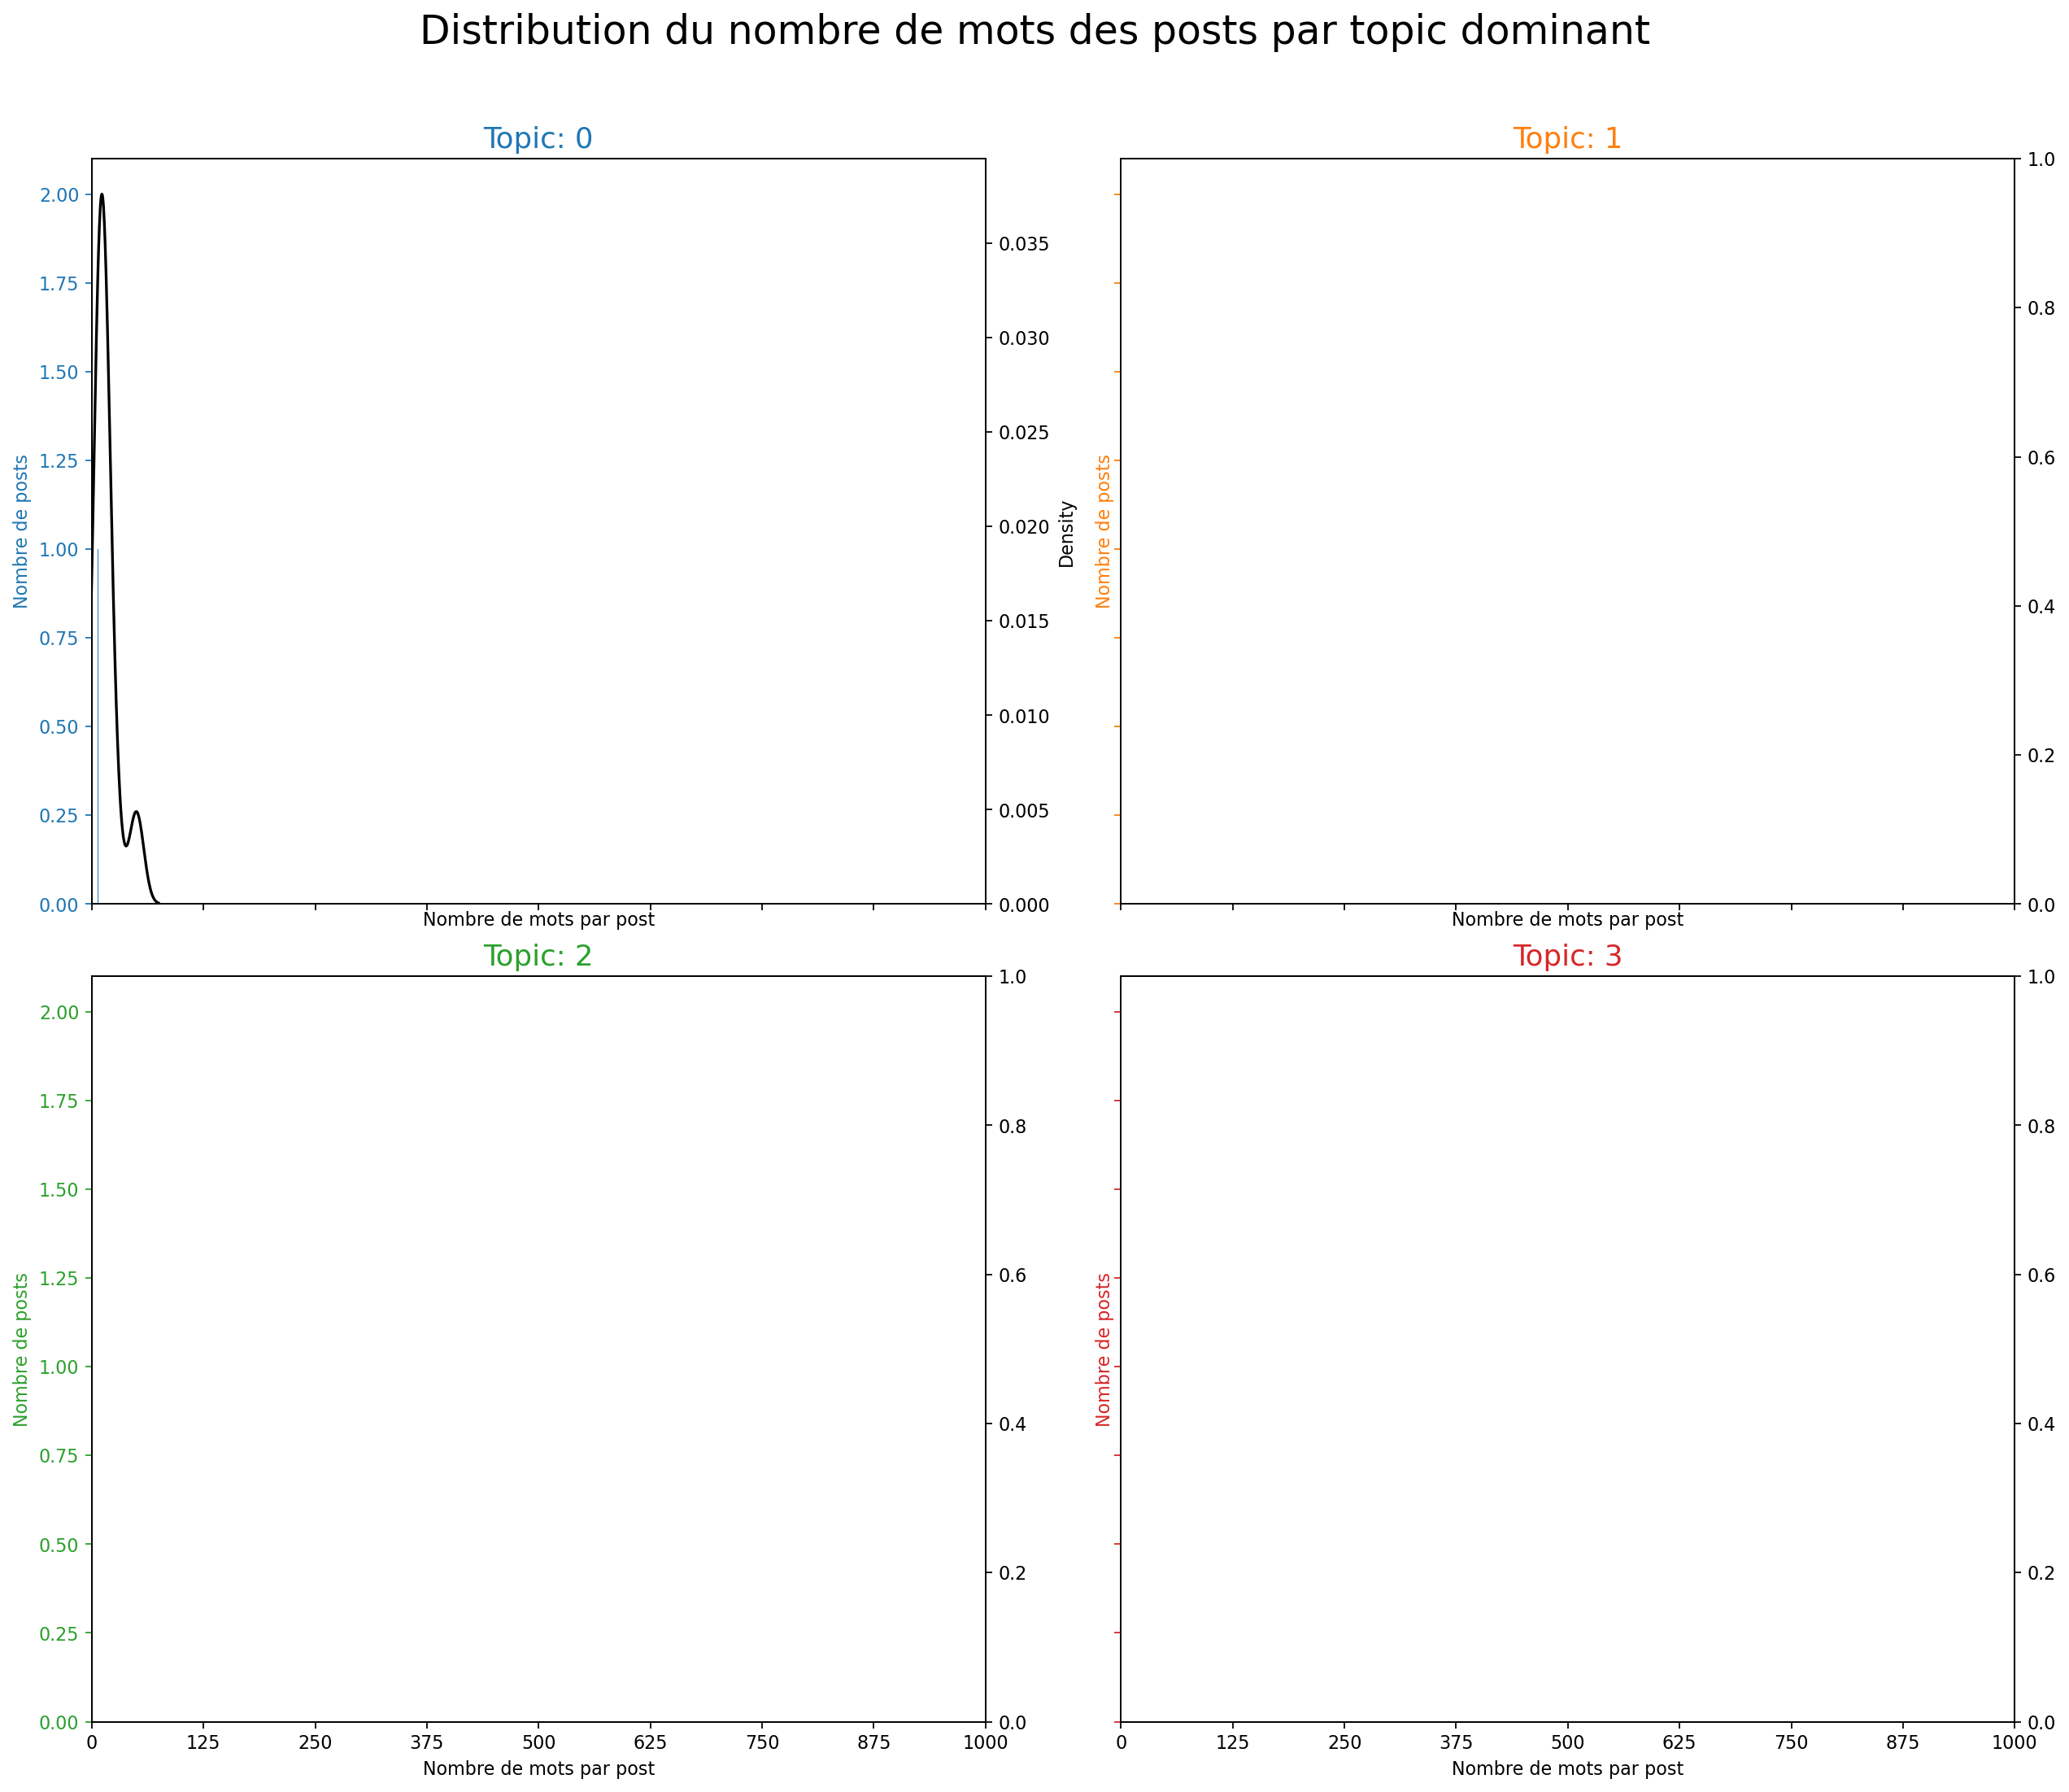

In [44]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Nombre de mots par post')
    ax.set_ylabel('Nombre de posts', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution du nombre de mots des posts par topic dominant', fontsize=22)
plt.show()

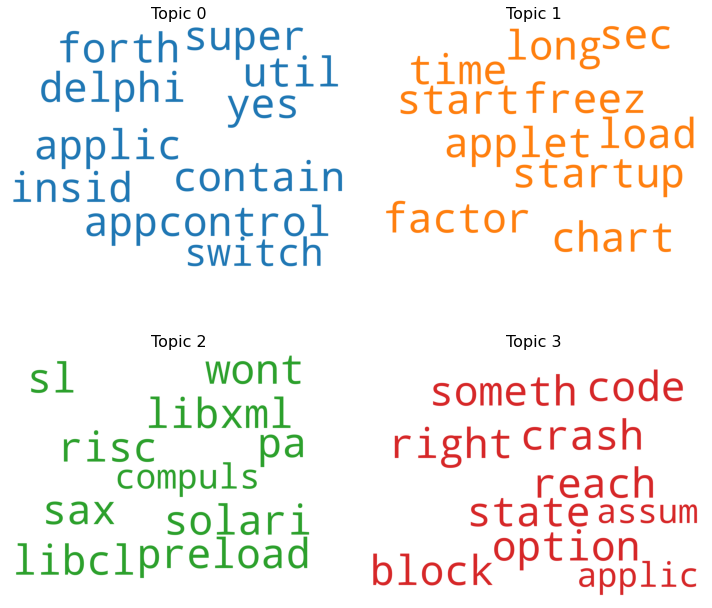

In [40]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf_optimized.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Nombre d'occurences d'un mot et poids dans les topics

On cherche à dégager les termes revenant souvent dans les topics dont la fréquence d'apparition est supérieure à leur poids dans le topic. 

Cela permet de montrer l'importance relative d'un terme dans le topic.

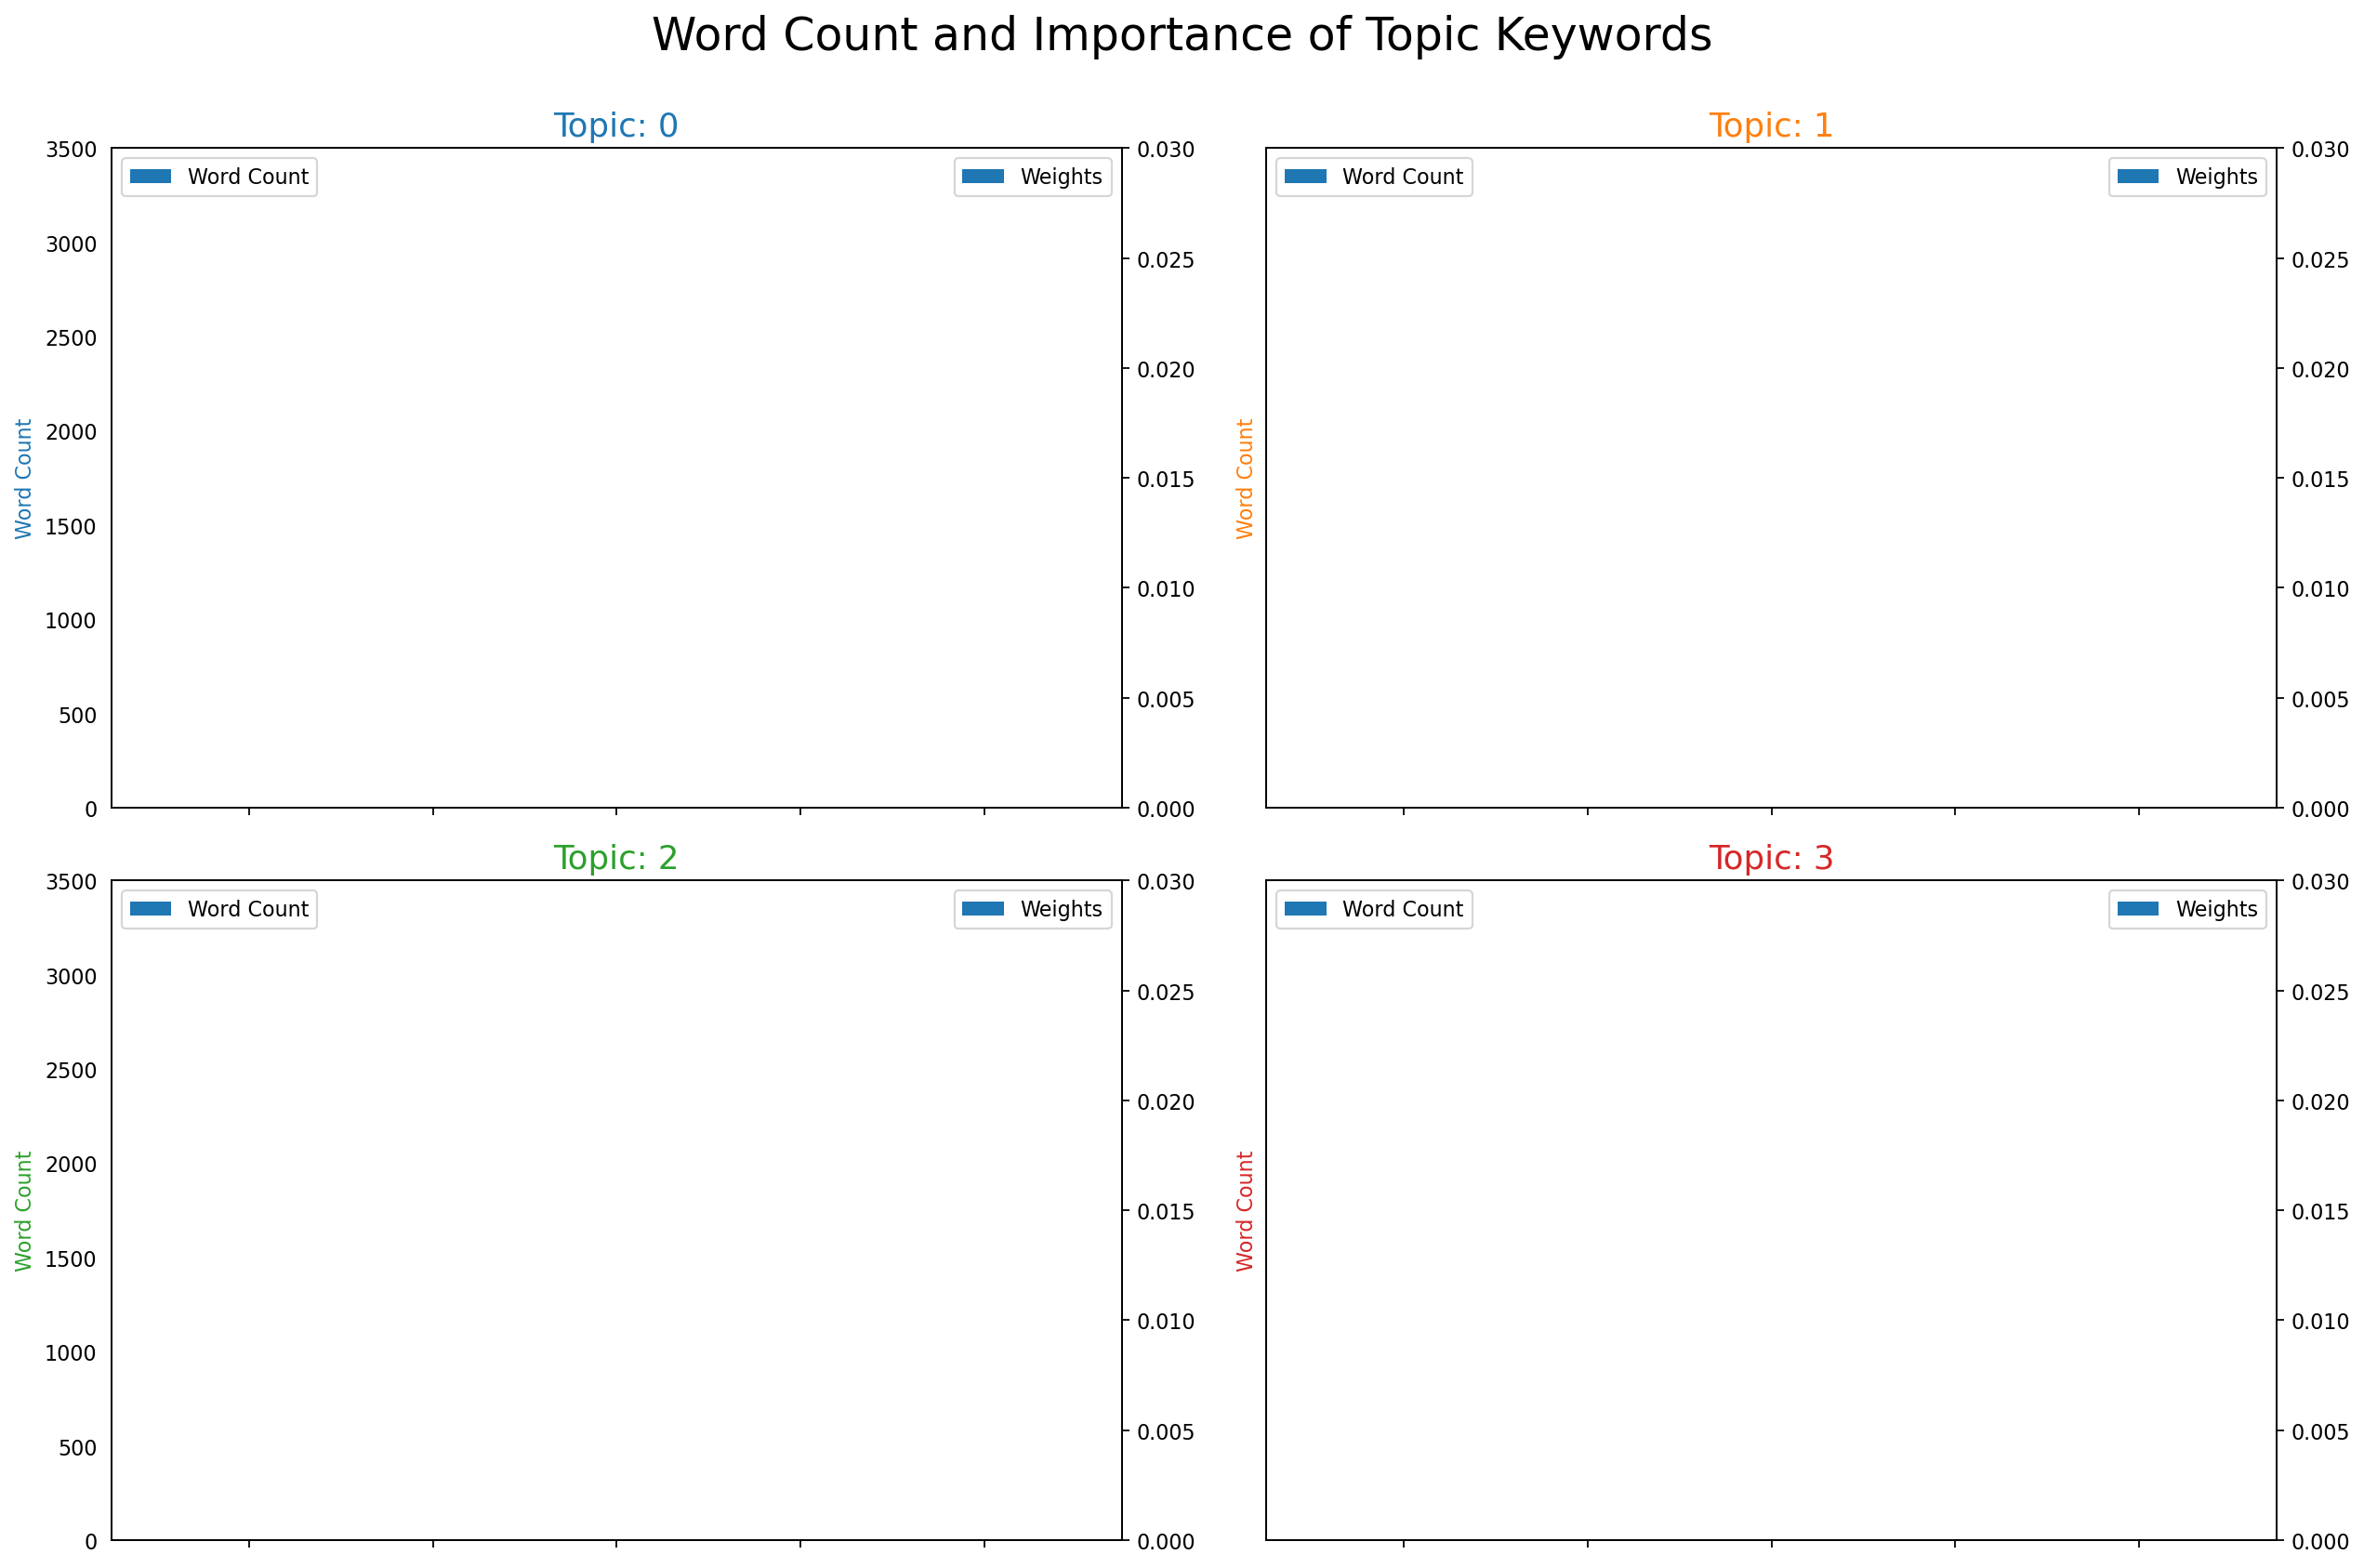

In [46]:

topics = lda_model_tfidf_optimized.show_topics(formatted=False)
data_flat = [w for w_list in processed_body for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Représentativité des topics

In [50]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(lda_model_tfidf_optimized, corpus_tfidf, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model_tfidf_optimized.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

On fait deux graphes: 
    
    Nombre de posts pour chaque topic auquel on assigne le post dans lequel il a le plus de poids 
    Nombre de topics pour chaque post où leur poids contribue significativement 

In [52]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x480 with 2 Axes>

#### Représentation t-SNE

In [54]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_tfidf_optimized[corpus_tfidf]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 941 samples in 0.028s...
[t-SNE] Computed neighbors for 941 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 941 / 941
[t-SNE] Mean sigma: 0.001396
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.905926
[t-SNE] KL divergence after 1000 iterations: 0.160520


Loading BokehJS ...

In [55]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf_optimized, corpus_tfidf, dictionary=lda_model_tfidf_optimized.id2word,mds='tsne')
vis

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x         y  topics  cluster       Freq
topic                                                          
49     0.063803+0.000000j  0.0+0.0j       1        1  82.836555
0     -0.000728+0.000000j  0.0+0.0j       2        1   0.192848
57    -0.000693+0.000000j  0.0+0.0j       3        1   0.192848
65    -0.000698+0.000000j -0.0+0.0j       4        1   0.192848
64    -0.000713+0.000000j -0.0+0.0j       5        1   0.192848
63    -0.000728+0.000000j  0.0+0.0j       6        1   0.192848
62    -0.000712+0.000000j -0.0+0.0j       7        1   0.192848
61    -0.000704+0.000000j  0.0+0.0j       8        1   0.192848
60    -0.000712+0.000000j -0.0+0.0j       9        1   0.192848
59    -0.000728+0.000000j  0.0+0.0j      10        1   0.192848
58    -0.000728+0.000000j  0.0+0.0j      11        1   0.192848
56    -0.000718+0.000000j -0.0+0.0j      12        1   0.192848
67    -0.000727+0.000000j  0.0+0.0j      13        1   0.192848
55    -0.

#### Représentation du modèle obtenu

In [24]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_tfidf_optimized, corpus_tfidf, dictionary)
LDAvis_prepared

/home/alpro/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x         y  topics  cluster       Freq
topic                                                          
49     0.063803+0.000000j  0.0+0.0j       1        1  82.825925
0     -0.000728+0.000000j  0.0+0.0j       2        1   0.192967
57    -0.000693+0.000000j  0.0+0.0j       3        1   0.192967
65    -0.000698+0.000000j -0.0+0.0j       4        1   0.192967
64    -0.000713+0.000000j -0.0+0.0j       5        1   0.192967
63    -0.000728+0.000000j  0.0+0.0j       6        1   0.192967
62    -0.000712+0.000000j -0.0+0.0j       7        1   0.192967
61    -0.000704+0.000000j  0.0+0.0j       8        1   0.192967
60    -0.000712+0.000000j -0.0+0.0j       9        1   0.192967
59    -0.000728+0.000000j  0.0+0.0j      10        1   0.192967
58    -0.000728+0.000000j  0.0+0.0j      11        1   0.192967
56    -0.000718+0.000000j -0.0+0.0j      12        1   0.192967
67    -0.000727+0.000000j  0.0+0.0j      13        1   0.192967
55    -0.

#### Création d'un dictionnaire des topics

In [37]:
topics_dictionary = []
for idx, topic in lda_model_tfidf_optimized.print_topics(-1):
    #t = set(topic.split('+'))
    #to_show = ' '.join(t)        
    #to_show = re.sub("[0-9]", "", topic)

    list_of_char = ['.', '*', '+', '"', "0",'1','2','3','4','5','6','7','8','9']
    pattern = '[' + ''.join(list_of_char) + ']'    
    to_show = re.sub(pattern, '', topic)
    
    print('Topic: {} Words: {}'.format(idx, to_show))
    topics_dictionary.append(to_show)

Topic: 0 Words: button  print  asp  html  postback  linq  click  insert  net  hello
Topic: 1 Words: argument  compat  browser  test  bash  script  return  close  function  formview
Topic: 2 Words: api  method  class  file  lectur  odbc  dbf  function  creat  dataitem
Topic: 3 Words: tabl  page  load  text  word  javascript  data  read  datetim  databas
Topic: 4 Words: declar  probe  implement  email  runtim  sign  interfac  ilist  mono  viewcontrol
Topic: 5 Words: cluster  string  sql  databas  newlin  express  port  heartbeat  line  iseri
Topic: 6 Words: page  session  free  gwt  maximum  result  mani  time  master  tabl
Topic: 7 Words: servic  dictionari  setter  duplic  code  dlls  textwrap  python  list  past
Topic: 8 Words: block  car  user  commit  pcap  asynchron  strength  comput  profil  packet
Topic: 9 Words: control  variabl  design  list  collect  ienumer  button  global  trust  helper
Topic: 10 Words: webservic  live  widget  oper  view  cursor  status  vba  hold  index
To

In [38]:
topics_dictionary[0]

'button  print  asp  html  postback  linq  click  insert  net  hello'

In [40]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)

NameError: name 'gcv_lda_1' is not defined

## Prédiction de topic pour un post donné

In [22]:
def find_topics(post_id, df, df_topics_pred, topic_dict, freq_min=0.1):
    print("Post n°{}:".format(post_id))
    print(df.iloc[post_id].body)
    print("\nTags : ", df.iloc[post_id].tags)
    print("")
    
    fig = plt.figure(figsize=(8, 6))
    df_topics_pred.iloc[post_id].plot()
    #for topic_id_curr in np.nonzero(
    #    df_topics_pred.iloc[quest_iloc] > freq_min)[0]:
    list_topic_labels = df_topics_pred.iloc[post_id][df_topics_pred.iloc[post_id] > freq_min].sort_values(ascending=False).index
    print(list_topic_labels)
    list_topic_id =[]
    for label_curr in list_topic_labels:
        list_topic_id.append(int(re.findall(r"\d+", label_curr)[0]))
    print(list_topic_id)
    for topic_id_curr in list_topic_id:
        print("Topic {} : {}".format(topic_id_curr, 
                                     topic_dict[topic_id_curr]))
    return list(list_topic_id)
    """

In [23]:
find_topics(0,data,topics_dictionary,data,0.1)

Post n°0:
programmat edit rout tabl write daemon run emb platform need chang default rout devic accord interfac connect give time programat know use system rout del default rout add default gateway blah etc direct way updat solv particular problem discov patch pppd allow replacedefaultrout option patch also includ code programmat modifi rout tabl includ gentoo bug report

Tags :  c,linux,networking

